### Basic Analysis of MovieLens 1M

#### Basic Stats

Number of Users|Possible Edges|Existing Edges|Graph Density
---|---|---|---
6040|18,237,780|17,472,510|0.958

![image.png](attachment:image.png)
    - The KDE for the node coverage percentage: the percentage of the number of neighboring nodes to the number of total nodes given a random node.

#### Data Generation

We aim to generate an edge table where the first two columns record the composing nodes of an undirected edge, and the third column stores the weight. Each node in the edge table represents an user in the MovieLens dataset, and if there is an edge connecting two nodes, it means there is at least one movie which both users have rated. The weight of the edge is the reciprocal of the numbers of movies rated by both users. The logic of using reciprocal instead of the factual number is that as weight is measured as distance in our context, yet the number of movies rated by both users weakly represents the similarity in terms of the willingness of rating, similar users should have smaller distance between each other, thus the use of reciprocal as weight agrees with this logic.

#### Sampling

Considering the size of the original graph is fairly large (6040 nodes and 17472510 edges), I have coded a sampler to generate a small sample that is friendly to community detection algorithms. It can be used to test the correctness of a community detection algorithm given a MovieLens edge table.

The sampler will randomly pick a root user node, and find a user defined number $x$ of its most similar neighboring nodes. Then the neighboring nodes will expend in the same fashion until a certain amount of total nodes have been met. The edges between silbing nodes and between a child node and its parents' silbing nodes are not allowed for clarity reason.

A community detection experiment can be found in the CD_on_Samples notebook.
    
#### Files 
    
- **edge_sample.csv**: The sampled dataset.
- **edges.csv**: The edge table for the MovieLens 1M dataset.
- **edges_spark.parquet**: The edge table for the MovieLens 1M dataset in spark parquet format.

In [ ]:
from pyspark.sql import SparkSession
from itertools import combinations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
spark = SparkSession.builder.appName("MoiveLens").getOrCreate()

In [2]:
rating_path = r"./MovieLens1M/ratings.dat"
rating_df = pd.read_csv(rating_path, sep='::',
                 names=["UserID","MovieID","Rating","TimeStamp"],
                 header=None,
                 encoding="utf-8",
                 engine='python')

In [3]:
def agg_distinct_users(series):
    users = series.tolist()
    return set(users)

In [4]:
%%time
users = rating_df.UserID.unique().tolist()
comb = list(combinations(users, 2))
groups = rating_df.groupby('MovieID').UserID.apply(agg_distinct_users)

CPU times: user 1.6 s, sys: 343 ms, total: 1.94 s
Wall time: 1.78 s


In [5]:
%%time
comb_dict = {key: 0 for key in comb}

CPU times: user 4.44 s, sys: 469 ms, total: 4.91 s
Wall time: 4.92 s


In [6]:
def populate_weights(comb_dict, groups):
    for users in groups:
        edges = list(combinations(users, 2))
        for edge in edges:
            if edge in comb_dict:
                comb_dict[edge] += 1
            elif (edge[1], edge[0]) in comb_dict:
                comb_dict[(edge[1], edge[0])] += 1

In [7]:
%%time
populate_weights(comb_dict, groups)
valid_edges = {k: v for k, v in comb_dict.items() if v != 0}

CPU times: user 4min 5s, sys: 7.75 s, total: 4min 12s
Wall time: 4min 13s


In [8]:
%%time
names = ["V1", "V2", "Weight"]

ve_list = list(valid_edges.items())
ve_list = [(i[0][0], i[0][1], i[1]) for i in ve_list]
df = pd.DataFrame(ve_list, columns=names)
df['Weight'] = df['Weight'].apply(lambda x: 1 / x)
df = df.round(5)

CPU times: user 14.3 s, sys: 2.53 s, total: 16.9 s
Wall time: 16.2 s


In [9]:
## Is there any isolated nodes?
assert(len(users) == len(set(list(df['V1'].unique()) + list(df['V2'].unique()))))
## Every node has at least one edge

In [10]:
%%time
df = df.sort_values(by=['V1', 'V2'])

CPU times: user 3.22 s, sys: 1.52 s, total: 4.74 s
Wall time: 4.37 s


In [11]:
df.head(10)

,V1,V2,Weight
0,1,2,0.14286
1,1,3,0.16667
2,1,4,0.25000
3,1,5,0.10000
4,1,6,0.10000
5,1,7,0.50000
6,1,8,0.10000
7,1,9,0.06667
8,1,10,0.02857
9,1,11,0.10000


In [12]:
%%time
df.to_csv("./edges.csv", index=False)

CPU times: user 47.4 s, sys: 566 ms, total: 48 s
Wall time: 48.2 s


In [13]:
%%time 
spark_df = spark.read.csv("./edges.csv", header=True)

CPU times: user 2.52 ms, sys: 1.54 ms, total: 4.06 ms
Wall time: 5.25 s


In [14]:
%%time
spark_df.write.parquet("./edges_spark.parquet")

CPU times: user 3.05 ms, sys: 3.22 ms, total: 6.27 ms
Wall time: 16.6 s


In [15]:
%%time
total_nodes = len(users) 
coverage_list = list()
for i in range(1, total_nodes + 1):
      coverage_list.append((i, df.loc[(df['V1'] == i) | (df['V2'] == i)].shape[0] / total_nodes))

CPU times: user 7min 30s, sys: 50 s, total: 8min 20s
Wall time: 4min 13s


In [16]:
np_clist = np.array([i[1] for i in coverage_list])
# Avg vertex degree 
print(f"#Avg Vertex Degree:{np_clist.sum() / len(users)}")
# The graph density
density = 2 * df.shape[0] / (len(users) * (len(users) - 1))
print(f"#Graph Density:{density}")

#Avg Vertex Degree:0.957880685057673
#Graph Density:0.958039300835957


[]

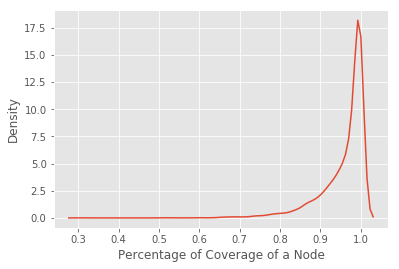

In [17]:
plt.style.use('ggplot')
ax = sns.distplot(np_clist, hist=False)
ax.set(xlabel="Percentage of Coverage of a Node", ylabel="Density")
ax.plot()

In [18]:
def sample_neighbors(node, df, size, ss):
    temp = df.loc[(df['V1'] == node) | (df['V2'] == node)]
    # Select the top quarter
    temp = temp.loc[temp['Weight'] < temp.Weight.mean()]
#     temp = temp.loc[temp['Weight'] < temp.Weight.mean()] #For a tighter weight constraint
    
    while(True):
        temp = temp.sample(size)
        neighbors = [i for i in list(temp.V1) + list(temp.V2) if i != node]
        
        resample = False
        for ne in neighbors:
            if ne in ss:
                resample = True
                size = size -1
        
        if (not resample) or (size == 0):
            break
    
    ne_edges = [(row['V1'], row['V2'], row['Weight']) for _,row in temp.iterrows()]
    
    return (neighbors, ne_edges)

In [19]:
def create_community(ss, df, root, counter):
    cons_nodes = list()
    ne, ne_edges = sample_neighbors(root, df, 5, ss)
    cons_nodes = [root] + ne.copy()
    cons_edges = ne_edges.copy()
    new_nodes = ne.copy()

    while(len(cons_nodes) <= 100):
        exh_nodes = new_nodes.copy()
        new_nodes = list()
        for node in exh_nodes:
            ne, ne_edges = sample_neighbors(node, df, 5, cons_nodes)
            cons_nodes = cons_nodes.copy() + ne.copy()
            cons_edges = cons_edges.copy() + ne_edges.copy()
            new_nodes = new_nodes.copy() + ne.copy()

    print(f"#Nodes={len(cons_nodes)} | Unique Nodes={len(set(cons_nodes))}")

    # Find Edge Between Silbings
    for x,y,z in cons_edges:
        find_same = 0
        for edge in cons_edges:
            if (x,y) == edge:
                find_same += 1
            if (y,x) == edge:
                find_same += 1
        if find_same == 2:
            cons_edges.remove(edge)  

    print(f"#Edges:{len(cons_edges)} | Unique Edges:{len(set(cons_edges))}") 
    
    return (cons_nodes, cons_edges)

In [20]:
def create_border(nodes, edges, border):
    root = np.random.choice(nodes, 1)[0]
    temp = list()
    for x,y,z in edges:
        if (x == root) or (y == root):
            temp.append((x,y,z))
    if len(temp) != 1:
        best_id = 0
        best = temp[0][2]
        for i,x in enumerate(temp):
            if best >= x[2]:
                best = x[2]
                best_id = i
        border.append(temp[best_id])
    elif len(temp) == 1:
        border.append(temp[0])
    return root

In [21]:
def create_communities(users, df, size=2):
    assert(size>=1)
    
    final_edges = list()
    border = list()
    counter = 1
    
    print(f"#Start creating Community {counter}")
    ss = list(range(1, len(users) + 1))
    root = np.random.choice(ss, 1)[0]
    nodes, edges = create_community(list([root]), df, root, 1)
    root = create_border(nodes, edges, border)
    final_edges = final_edges.copy() + edges.copy()

    for counter in range(2, size + 1):
        print(f"#Start creating Community {counter}")
        nodes, edges = create_community(nodes, df, root, counter)
        root = create_border(nodes, edges, border)
        final_edges = final_edges.copy() + edges.copy()

    return (final_edges, border)

In [22]:
edges, border = create_communities(users, df, 1)

#Start creating Community 1
#Nodes=144 | Unique Nodes=141
#Edges:143 | Unique Edges:143


In [23]:
sample_df = pd.DataFrame(edges, columns=names)
sample_df = sample_df.astype({'V1':int, 'V2':int}).round(5)
sample_df = sample_df.sort_values(['V1', 'V2'])
sample_df.to_csv("./edge_sample.csv", index=False, header=True)